In [35]:
import pandas as pd
import numpy as np
from datetime import datetime

# 读取你的采集数据
df = pd.read_csv("../data/processed/20251118_bus142_tracking.csv")

df["timestamp"] = pd.to_datetime(df["timestamp"])
df["next_stop"] = df["next_stop"].str.replace(r"\s*\(Berlin\)", "", regex=True)


start = df["timestamp"].min()
end = df["timestamp"].max()
duration = end - start

print("开始采集时间：", start)
print("结束采集时间：", end)
print("总采集时长：", duration)


开始采集时间： 2025-11-18 14:52:52.677230+01:00
结束采集时间： 2025-11-18 22:00:06.638563+01:00
总采集时长： 0 days 07:07:13.961333


In [36]:
def classify_direction(s):
    if pd.isna(s):
        return "Unknown"
    s = s.lower()
    if "leopold" in s:
        return "Leopoldplatz"
    if "ostbahnhof" in s:
        return "Ostbahnhof"
    return "Other"

df["direction_group"] = df["direction"].apply(classify_direction)

In [37]:
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # 地球半径 (km)
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df = df.sort_values(["tripId", "timestamp"])

df["lon_prev"] = df.groupby("tripId")["lon"].shift(1)
df["lat_prev"] = df.groupby("tripId")["lat"].shift(1)
df["time_prev"] = df.groupby("tripId")["timestamp"].shift(1)


df["dist_km"] = haversine(
    df["lon_prev"], df["lat_prev"],
    df["lon"], df["lat"]
)
df["time_diff_h"] = (df["timestamp"] - df["time_prev"]).dt.total_seconds() / 3600
df["speed_kmh"] = df["dist_km"] / df["time_diff_h"]
df.loc[df["speed_kmh"] > 100, "speed_kmh"] = np.nan  # 去除异常值



In [5]:
unique_trips = df["tripId"].nunique()
print("不同车辆（tripId）数量：", unique_trips)

不同车辆（tripId）数量： 47


In [34]:
df["next_stop"].unique()

array(['Tucholskystr.', 'Fennbrücke', 'U Amrumer Str.', 'Samoastr.',
       'Kiautschoustr.', 'Luxemburger Str.', 'U Rosenthaler Platz',
       'Hannoversche Str.', 'U Leopoldplatz', 'Robert-Koch-Platz',
       'Perleberger Brücke', 'U Rosa-Luxemburg-Platz', 'Invalidenpark',
       'Kruppstr.', 'Poststadion', 'S+U Berlin Hauptbahnhof',
       'Seydlitzstr.', 'Lehrter Str./Invalidenstr.', 'Philippstr.'],
      dtype=object)

In [ ]:
# 按 trip 和时间排序
df = df.sort_values(["tripId", "timestamp"])

# 计算前一个 next_stop
df["next_stop_prev"] = df.groupby("tripId")["next_stop"].shift(1)

# 判断到站事件：next_stop 名称变化 → 到站
mask_arrival = (
    (df["next_stop"] != df["next_stop_prev"]) &
    df["next_stop_prev"].notna()
)

arrivals = df[mask_arrival].copy()

arrivals = arrivals[[
    "tripId",
    "timestamp",
    "next_stop_prev",      # 到达的站
    "delay_sec",
    "direction_group",
]]

arrivals.rename(columns={"next_stop_prev": "arrived_stop"}, inplace=True)

stop_order = [
    'U Leopoldplatz',
    'Luxemburger Str.',
    'U Amrumer Str.', 
    'Samoastr.',
    'Kiautschoustr.', 
    'Fennbrücke',
    'Perleberger Brücke',
    'Kruppstr.',
    'Poststadion',
    'Seydlitzstr.',
    'Lehrter Str./Invalidenstr.',
    'S+U Berlin Hauptbahnhof',
    'Invalidenpark',
    'Robert-Koch-Platz',
    'Philippstr.'
    'Hannoversche Str.', 
    'Tucholskystr.',  
    'U Rosenthaler Platz',
    'U Rosa-Luxemburg-Platz', 
]

arrivals["arrived_stop"] = pd.Categorical(
    arrivals["arrived_stop"],
    categories=stop_order,
    ordered=True
)

arrivals["arrival_time"] = arrivals["timestamp"].dt.strftime("%H")

# 将 arrival_time 也转为有序 category（00:00 → 23:59）
times_sorted = sorted(arrivals["arrival_time"].unique())
arrivals["arrival_time"] = pd.Categorical(arrivals["arrival_time"], categories=times_sorted, ordered=True)

delay_stats = (
    arrivals.groupby(["direction_group", "arrived_stop"])["delay_sec"]
    .median()
    .reset_index()
)


C:\Users\iwasz\AppData\Local\Temp\ipykernel_16052\2054970288.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  arrivals.groupby(["direction_group", "arrived_stop"])["delay_sec"]


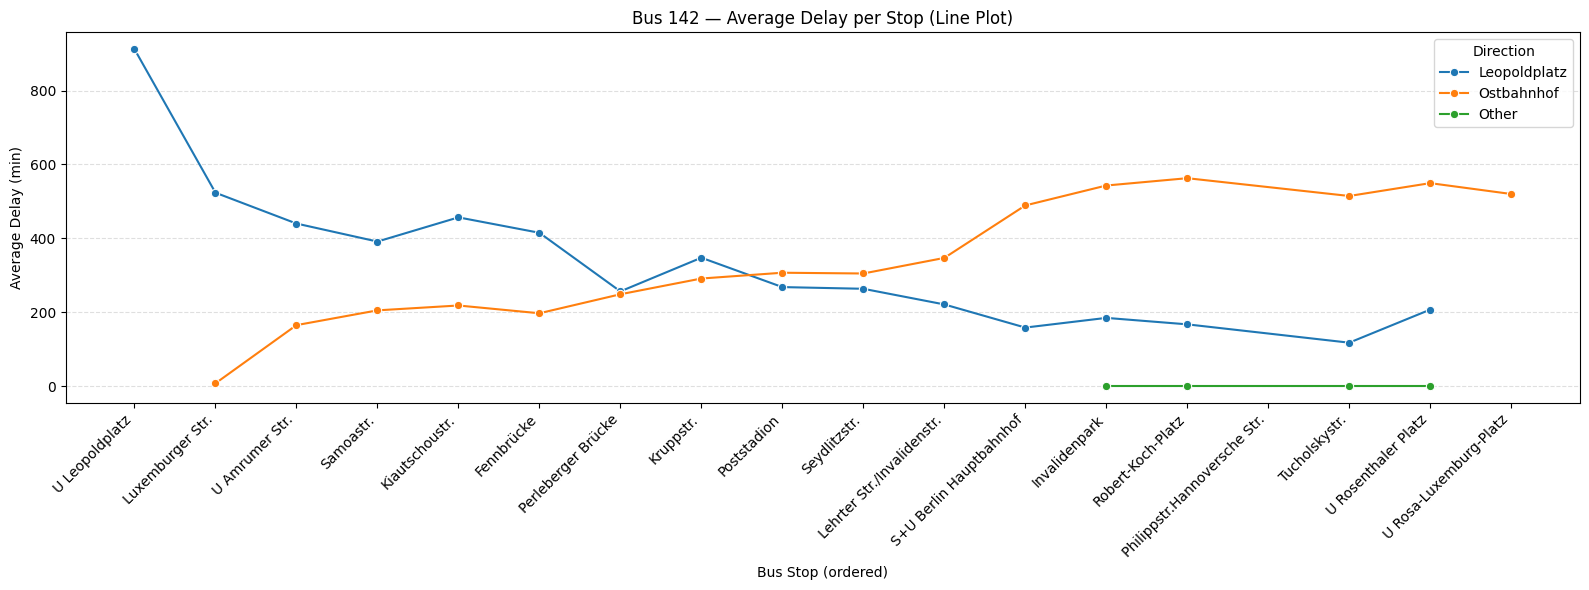

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))

sns.lineplot(
    data=delay_stats,
    x="arrived_stop",
    y="delay_sec",
    hue="direction_group",
    marker="o"
)

plt.title("Bus 142 — Average Delay per Stop (Line Plot)")
plt.xlabel("Bus Stop (ordered)")
plt.ylabel("Average Delay (min)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.legend(title="Direction")
plt.tight_layout()
plt.show()


C:\Users\iwasz\AppData\Local\Temp\ipykernel_16052\3160609259.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heat_leo = df_leo.pivot_table(
C:\Users\iwasz\AppData\Local\Temp\ipykernel_16052\3160609259.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heat_ost = df_ost.pivot_table(


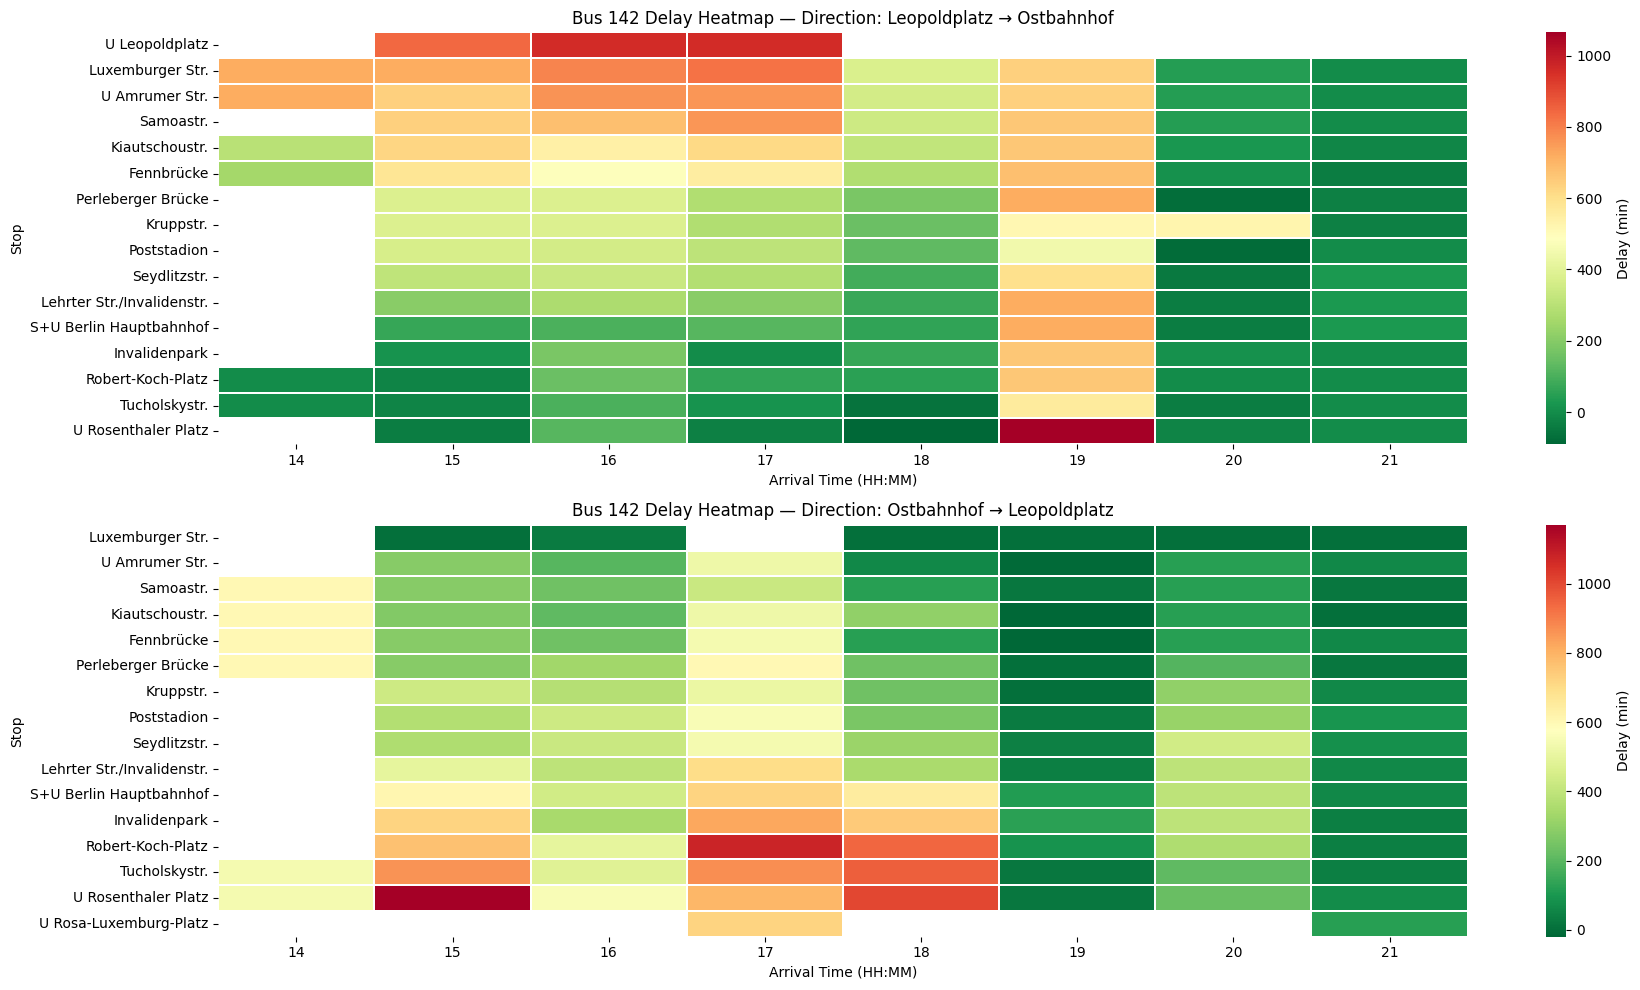

In [43]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 分方向
df_leo = arrivals[arrivals["direction_group"] == "Leopoldplatz"]
df_ost = arrivals[arrivals["direction_group"] == "Ostbahnhof"]

# pivot：行 = 时间，列 = 站名，值 = 平均晚点
heat_leo = df_leo.pivot_table(
    index= "arrived_stop",
    columns="arrival_time",
    values="delay_sec",
    aggfunc="mean"
)

heat_ost = df_ost.pivot_table(
    index= "arrived_stop",
    columns="arrival_time",
    values="delay_sec",
    aggfunc="mean"
)

plt.figure(figsize=(18,10))

# --- Heatmap 1: Leopoldplatz 方向 ---
plt.subplot(2,1,1)
sns.heatmap(
    heat_leo,
    cmap="RdYlGn_r",    # green → yellow → red
    linewidths=.3,
    cbar_kws={'label': 'Delay (min)'}
)
plt.title("Bus 142 Delay Heatmap — Direction: Leopoldplatz → Ostbahnhof")
plt.ylabel("Stop")
plt.xlabel("Arrival Time (HH:MM)")


# --- Heatmap 2: Ostbahnhof 方向 ---
plt.subplot(2,1,2)
sns.heatmap(
    heat_ost,
    cmap="RdYlGn_r",
    linewidths=.3,
    cbar_kws={'label': 'Delay (min)'}
)
plt.title("Bus 142 Delay Heatmap — Direction: Ostbahnhof → Leopoldplatz")
plt.ylabel("Stop")
plt.xlabel("Arrival Time (HH:MM)")


plt.tight_layout()
plt.show()
